# crms_integrated_heatmap

to show tissue relationships (also pair with R to create dendrograms and heatmaps


also used to read in `run_irf.py` or `crms_irf_041520.ipynb` results to create a heatmap

# 0. startup


In [1]:
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import itertools
from scipy.stats.stats import pearsonr

from collections import Counter, defaultdict
import time
from sklearn.preprocessing import OneHotEncoder

In [2]:
# loading files

In [3]:
hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
hoco_annon = pd.read_table(hoco_annon_file,header=0)
hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
hoco_motif_to_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
tfs = list(hoco_annon['Transcription factor'])

In [4]:
THRES=1
rna_tpm_file = 'rnaseq/tissue_tpm_sym.csv'
rna_df = pd.read_csv(rna_tpm_file, index_col=0,header=0)
rna_df.index = [x.upper() for x in rna_df.index.values]
all_genes = rna_df.index
tissue_diffloop_to_rna = {
    'Air':'Airway', 'Astro':'Astrocytes', 'Blad':'Bladder', 'Colon':'Colon', 'Eso':'Esophageal', 
    'GDSD0':'GDSD0', 'GDSD3':'GDSD3', 'GDSD6':'GDSD6', 
    'GM12878':'GM12878', 'HMEC':'HMEC', 'MC':'Melanocytes', 'Ova':'Ovarian',
    'Panc':'Pancreas', 'Pros':'Prostate', 'Renal':'Renal', 'Thy':'Thyroid', 'Uter':'Uterine'
}

def get_exp(rna_df, sym, tissue,verbose=True):
    try:
        return rna_df.loc[sym,tissue]
    except KeyError:
        if verbose:
            print(sym, 'not found')
        return 0

In [5]:
# loop_files = sorted(glob.glob('diffloop_data/bedpe_files_csvs_rna/*merged.loops.csv'))
# anchor_files = sorted(glob.glob('diffloop_data/bedpe_files_csvs_rna/*merged.anchors.csv'))
# print(loop_files)
# print(anchor_files)

In [6]:
# crm_files = sorted(glob.glob('networks/diffgene/all_no_thres/*_crm_tissue.csv'))
# crm_files

In [5]:
# tissues = []
# for crm in crm_files:
#     tissues.append(os.path.basename(crm).split('_')[1])
# tissue_dict = dict(zip(tissues,range(len(tissues))))
tissue_dict = {'Air': 0,
 'Astro': 1,
 'Blad': 2,
 'Colon': 3,
 'Eso': 4,
 'GDSD0': 5,
 'GDSD3': 6,
 'GDSD6': 7,
 'GM12878': 8,
 'HMEC': 9,
 'MC': 10,
 'Ova': 11,
 'Panc': 12,
 'Pros': 13,
 'Renal': 14,
 'Thy': 15,
 'Uter': 16}


# 2. Machine learning expression



In [7]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing, metrics
from scipy import interp
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

## Data preprocessing and importing

In [8]:
%%time
data_all = pd.read_csv('pan_omics/data/processed/tissue_crms/all_count_comb_overall.csv',index_col=0,header=0)

In [13]:
data_all_normal[:5]

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,NFE2_pro,NKX6-1_pro,ZIC1_pro,NFE2_loop,NKX6-1_loop,ZIC1_loop,E2F5_pro,E2F5_loop,ESR2_pro,ESR2_loop
A1BG,Colon,0.200,35.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,Colon,0.130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,Colon,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,Colon,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,Colon,0.010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data_all_normal = data_all[data_all.tissue.isin(tissue_dict.keys())]
data_all_normal.shape

(173677, 686)

In [15]:
THRES = 1
labels_all = data_all_normal.exp > THRES
# labels_all = np.array(pd.read_csv('networks/representations_no_tfs/labels_all.csv',index_col=0,header=None))

In [11]:
genes_all = np.array(data_all_normal.index)

In [18]:
tissue_df = pd.DataFrame(data_all_normal.reset_index().tissue)
tissue_df['tissue_num'] = tissue_df.tissue.map(tissue_dict)

,tissue
0,Colon
1,Colon
2,Colon
3,Colon
4,Colon
...,...
173672,Renal
173673,Renal
173674,Renal
173675,Renal


In [12]:
data_all.shape, labels_all.shape,genes_all.shape


((291006, 824), (291006, 1), (291006, 1))

preprocess genes by converting into number

In [13]:
labels_all_bin = [1 if x > THRES else 0 for x in labels_all]

In [14]:
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))

In [15]:
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)

 preprocess tissues

In [16]:
# tissue_index_dict = {}
# for tissue in tissue_dict.keys():
#     tissue_index_dict[tissue] = np.where(data_all.loc[:,tissue]==1)[0]
tissue_to_num_dict = dict(zip(tissue_dict.keys(), range(len(tissue_dict.keys()))))
tissue_df = data_all[tissue_dict.keys()].reset_index().melt('index')
tissue_df.columns = ['index','tissue','value']
tissue_df = tissue_df[tissue_df.value==1].reset_index(drop=True)
tissue_df['tissue_num'] = tissue_df.tissue.map(tissue_to_num_dict)
tissue_df[:5]

,index,tissue,value,tissue_num
0,0,Air,1.0,0
1,1,Air,1.0,0
2,2,Air,1.0,0
3,3,Air,1.0,0
4,4,Air,1.0,0


In [17]:
tissue_labels = np.array(tissue_df.tissue)
tissue_num_labels = np.array(tissue_df.tissue_num)
tissue_labels.shape

(291006,)

In [18]:
Counter(tissue_labels)

Counter({'Air': 17118,
         'Astro': 17118,
         'Blad': 17118,
         'Colon': 17118,
         'Eso': 17118,
         'GDSD0': 17118,
         'GDSD3': 17118,
         'GDSD6': 17118,
         'GM12878': 17118,
         'HMEC': 17118,
         'MC': 17118,
         'Ova': 17118,
         'Panc': 17118,
         'Pros': 17118,
         'Renal': 17118,
         'Thy': 17118,
         'Uter': 17118})

In [19]:
data_all_no_tissue = data_all.copy()

for tissue in tissue_dict.keys():
    data_all_no_tissue.drop(tissue,axis=1,inplace=True)

data_all_no_tissue.shape

(291006, 807)

In [20]:
# preprocessing, remove zero variance columns, and scale rest of columns 
# remove tissue info
# if 'log_exp' in data_all_no_tissue.columns:
#     data_all_no_tissue.drop('log_exp',axis=1,inplace=True)

# keep gene expression value
# maybe add in gene?
if '_loop' in data_all_no_tissue.columns:
    data_all_no_tissue.drop('_loop',axis=1,inplace=True)
    
data_all_no_tissue['log_exp'] = labels_all
data_all_no_tissue['gene_num'] = genes_num_all
   

    
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all_no_tissue)
data_all_varfilt_cols = data_all_no_tissue.columns[selector.get_support()]
print(data_all_no_tissue.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
print(data_all_varfilt.shape, data_all_norm.shape)


(291006, 808) (291006, 654) 654
(291006, 654) (291006, 654)


In [21]:
'log_exp' in data_all_varfilt_cols

True

In [22]:
# # save for R analyzes
# if '_loop' in data_all_no_tissue.columns:
#     data_all_no_tissue.drop('_loop',axis=1,inplace=True)
# data_all_no_tissue.reset_index(drop=True, inplace=True)
 
# data_all_df = pd.concat([data_all_no_tissue, tissue_df['tissue'],pd.DataFrame(genes_all,columns=['gene'])],axis=1)
# # 

In [23]:
# data_all_no_tissue.shape, tissue_df.shape, pd.DataFrame(genes_all,columns=['gene']).shape, data_all_df.shape
# data_all_df.to_csv('networks/representations_no_tfs/data_all_df.csv')

In [24]:
# Counter(data_all_df['tissue'])

In [25]:
save_dir = 'networks/representations_cell_type_specific_050720'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# RF check

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


In [ ]:
Counter(train_labels)

In [ ]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


In [ ]:
# fpr, tpr, thresholds = metrics.roc_curve(test_labels, rf_probs, pos_label=1)
# fig, ax = plt.subplots()
# ax.plot(fpr,tpr)
# plot_roc_curve(model, test_features, test_labels, multi_class='ovr') 

In [ ]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)
# # Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
print(roc_value)

# 4 Clustering

Dimensionality reduction 

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [27]:
data_all_norm_df = pd.DataFrame(data_all_norm, columns=data_all_varfilt_cols)

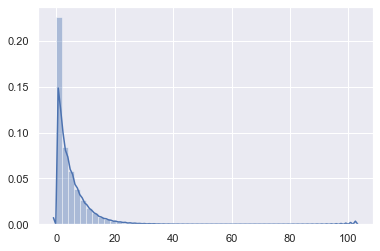

In [28]:
sns.distplot(data_all_norm_df.sum(axis=1))

In [29]:
data_all_norm_df = pd.concat([data_all_norm_df, tissue_df['tissue'],pd.DataFrame(genes_all,columns=['gene'])],axis=1)

In [30]:
np.unique(genes_all).shape

(17118,)

In [31]:
data_all_norm_df.shape

(291006, 656)

### 4A PCA

In [32]:
data_all_norm

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.01445203e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.81042242e-08, 5.84214524e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.16842905e-04],
       ...,
       [0.00000000e+00, 1.66666667e-01, 0.00000000e+00, ...,
        0.00000000e+00, 3.62397004e-04, 9.99883157e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.25000000e-02, 1.83454899e-05, 9.99941579e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.63317173e-05, 1.00000000e+00]])

In [33]:
%%time
n_comp = 25
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(data_all_norm_df[data_all_varfilt_cols].values)


CPU times: user 43.7 s, sys: 7.41 s, total: 51.1 s
Wall time: 5.92 s


In [34]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)

Explained variation per principal component: [0.09269922 0.07568042 0.04283563 0.02975308 0.02862893 0.01522296
 0.01434135 0.01369804 0.01261554 0.0108294  0.01021237 0.00900224
 0.00806763 0.00764559 0.00721338 0.00698164 0.00675928 0.00647534
 0.00621267 0.00592007 0.00584267 0.00564544 0.00558005 0.00540102
 0.00532689]


0.43859085288868516

In [35]:
for i in range(n_comp):
    data_all_norm_df['pc_'+str(i+1)] = pca_result[:,i]


In [36]:
data_all_norm_df.gene_num

0         0.000000
1         0.000058
2         0.000117
3         0.000175
4         0.000234
            ...   
291001    0.999766
291002    0.999825
291003    0.999883
291004    0.999942
291005    1.000000
Name: gene_num, Length: 291006, dtype: float64

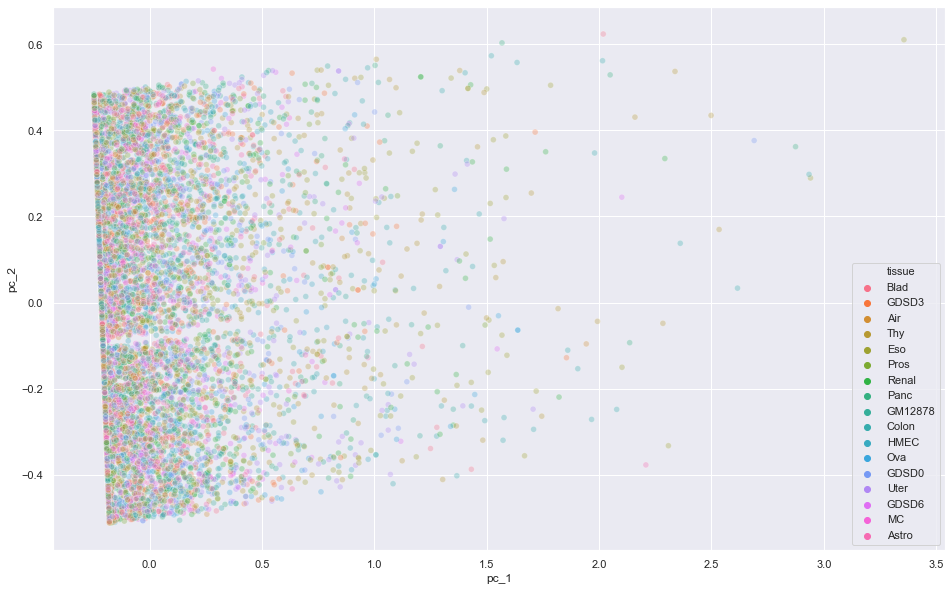

In [37]:
idx_choice = np.random.choice(data_all_norm_df.index.values, 10000)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pc_1', y='pc_2',
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_pca12_'+str(n_comp)+'.png'))

In [58]:
# figure out what's responsible for a pc space
pc2_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_2_coeff':pca.components_[1]})#,orient='index')
pc2_df['pc_2_coeff_abs'] = abs(pc2_df['pc_2_coeff'])
pc2_df.sort_values('pc_2_coeff_abs',ascending=False)

,features,pc_2_coeff,pc_2_coeff_abs
653,gene_num,-9.971818e-01,9.971818e-01
435,SP1_loop,1.086943e-02,1.086943e-02
439,SP3_loop,1.034853e-02,1.034853e-02
531,ZBTB17_loop,1.008800e-02,1.008800e-02
223,KLF6_loop,9.917214e-03,9.917214e-03
...,...,...,...
360,POU3F2_anc,-2.449803e-06,2.449803e-06
431,SOX5_loop,2.158089e-06,2.158089e-06
270,MYB_anc,-9.147792e-07,9.147792e-07
103,ETV2_loop,-8.858044e-07,8.858044e-07


In [59]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 1000)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x='pc_1', y='pc_2',
#     hue="gene",
# #     palette=sns.color_palette("hls", 10),
#     data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
#     legend="brief",
#     alpha=0.3
# )
# plt.savefig(os.path.join('networks/representations', 'dimred_pca12_gene_'+str(n_comp)+'.png'))

for each gene, calculate pairwise distance between all the tissues

~17x17x20000

average out last row

In [39]:
from sklearn.metrics.pairwise import euclidean_distances

In [43]:
all_expr_genes_tpm1 = list(pd.read_csv('rnaseq/all_expr_genes_tpm1.csv')['x'])
print(len(all_expr_genes_tpm1))

gene_in_highexpr_bool = np.isin(genes_all, all_expr_genes_tpm1)
gene_in_highexpr_bool_idx = np.where(gene_in_highexpr_bool)[0]
len(gene_in_highexpr_bool_idx)

7091


107780

In [45]:
housekeeping_df = pd.read_table(os.path.join('annon', 'HSIAO_HOUSEKEEPING_GENES.txt'),skiprows=2, header=None)
housekeeping_df.columns = ['genes']
housekeeping_genes_list = list(housekeeping_df.genes)
len(housekeeping_genes_list)


398

In [46]:
# takes a long time
gene_in_hk_bool = np.isin(genes_all, housekeeping_genes_list)
gene_in_hk_bool_idx = np.where(gene_in_hk_bool)[0]
len(gene_in_hk_bool_idx)

6205

In [58]:
num_tissues = len( np.unique(tissue_num_labels))
# num_genes = len(housekeeping_genes_list)
num_genes = len( np.unique(genes_all))
# num_genes = len(all_expr_genes_tpm1)
tissue_pairwisedist_gene = np.zeros((num_tissues, num_tissues, num_genes))
tissue_pairwisedist_gene.shape

(17, 17, 17118)

In [48]:
pca_result.shape

(291006, 25)

In [61]:
%%time
for idx, gene in enumerate(np.unique(genes_all)):
# for idx, gene in enumerate(np.unique(housekeeping_genes_list)):
# for idx, gene in enumerate(np.unique(all_expr_genes_tpm1)):
    if (idx % 1000)==0:
        print(idx)
    gene_select_idx = np.where(genes_all==gene)[0]
    if len(gene_select_idx)>0:
        tissues_select = tissue_num_labels[gene_select_idx]
#         data_select = data_all_norm[gene_select_idx,:]
        data_select = pca_result[gene_select_idx,:]
        data_select_tissue_ord = data_select[:,tissues_select]
        tissue_pairwisedist_gene[:,:,idx] = euclidean_distances(data_select_tissue_ord, data_select_tissue_ord)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
CPU times: user 1min 19s, sys: 98.5 ms, total: 1min 19s
Wall time: 1min 19s


In [62]:
tissue_pairwisedist_gene.shape

(17, 17, 17118)

In [63]:
tissue_to_num_dict.keys()

dict_keys(['Air', 'Astro', 'Blad', 'Colon', 'Eso', 'GDSD0', 'GDSD3', 'GDSD6', 'GM12878', 'HMEC', 'MC', 'Ova', 'Panc', 'Pros', 'Renal', 'Thy', 'Uter'])

In [67]:
np.median(tissue_pairwisedist_gene[2,3])

0.20969480627421433

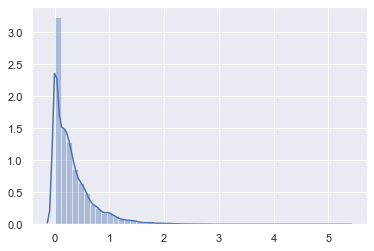

In [64]:
sns.distplot(tissue_pairwisedist_gene[2,3,:])

In [56]:
tissue_pairwisedist_gene_mean_df = pd.DataFrame(tissue_pairwisedist_gene.mean(axis=2),columns=tissue_to_num_dict.keys(),index=tissue_to_num_dict.keys())
filepath = os.path.join(save_dir, 'tissue_pairwisedist_tpm1gene_crm_pca_mean.csv')
tissue_pairwisedist_gene_mean_df.to_csv(filepath)
print(filepath)

networks/representations_cell_type_specific/tissue_pairwisedist_tpm1gene_crm_pca_mean.csv


In [57]:
tissue_pairwisedist_gene_sum_df = pd.DataFrame(tissue_pairwisedist_gene.sum(axis=2),columns=tissue_to_num_dict.keys(),index=tissue_to_num_dict.keys())
filepath = os.path.join(save_dir, 'tissue_pairwisedist_tpm1gene_crm_pca_sum.csv')
tissue_pairwisedist_gene_sum_df.to_csv(filepath)
print(filepath)

networks/representations_cell_type_specific/tissue_pairwisedist_tpm1gene_crm_pca_sum.csv


### 4B: tsne

In [ ]:
idx_choice = np.random.choice(data_all_norm_df.index.values, 10000)
data_all_norm_df_subset = data_all_norm_df.loc[idx_choice]

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[idx_choice,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
data_all_norm_df_subset['tsne-2d-one'] = tsne_results[:,0]
data_all_norm_df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2.png'))

### 4C UMAP

In [ ]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_result[idx_choice,:])
embedding.shape

In [ ]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap.png'))

In [211]:
genes_all[labels_all_bin]

array([['A1BG'],
       ['A1CF'],
       ['A2M'],
       ...,
       ['ZYX'],
       ['ZZEF1'],
       ['ZZZ3']], dtype=object)

In [216]:
genes_all_count = Counter(list(genes_all[labels_all_bin]))

TypeError: unhashable type: 'numpy.ndarray'

In [243]:
gene_count = {}
for gene in genes_all[np.array(labels_all_bin)==1][:,0]:
    if gene in gene_count.keys():
        gene_count[gene]+=1
    else:
        gene_count[gene]=1

In [242]:
labels_all_bin==1

False

In [246]:
common_genes = []
for gene,count in gene_count.items():
     if count==17:
            common_genes.append(gene)
len(common_genes)

6341

# Looking at CRMs data to RF to pick cell type specific TFs

rf_tissue, the tissue used to train the model this is like learning the tissue specific vocabulary for this tissue

`gene_tissue` these are the cell type specific gene lists made, some are better than others (GDSD6, Astrocyte, Melanocytes,GM12878, 

In [82]:
tissue_to_feature_dict = {}
for file in glob.glob('networks/representations_irf_cell_type/*feature_importances.csv'):
    info = os.path.basename(file).split('_')
    rf_tissue = info[0]
    gene_tissue = info[2]
    if rf_tissue == gene_tissue:
        df = pd.read_csv(file)
        feature_dict = pd.Series(df.importance.values, index=df.feature.values).to_dict()
        tissue_to_feature_dict[rf_tissue] = feature_dict

In [85]:
savefile = 'networks/representations_irf_cell_type/tissue_feature_df.csv'
pd.DataFrame(tissue_to_feature_dict).to_csv(savefile)

In [2]:
# for all genes features
tissue_to_feature_dict = {}
for file in glob.glob('networks/representations_irf_cell_type/*all_genes_feature_importances.csv'):
    info = os.path.basename(file).split('_')
    rf_tissue = info[0]
    gene_tissue = info[2]
    if rf_tissue == gene_tissue:
        df = pd.read_csv(file)
        feature_dict = pd.Series(df.importance.values, index=df.feature.values).to_dict()
        tissue_to_feature_dict[rf_tissue] = feature_dict

In [5]:
savefile = 'networks/representations_irf_cell_type/tissue_all_gene_feature_df.csv'
pd.DataFrame(tissue_to_feature_dict).to_csv(savefile)